# Info 

This notebook contains code for generating *scikit-allel* dbs for the sequence capture dataset, which makes it easy to quickly look at things like DXY, FST, etc.

# Setup

In [1]:
import sys,os,re,glob,shutil,pickle,subprocess
import dill
import pandas as pd
import numpy as np
import time
import random
import math
import itertools
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
%matplotlib inline

from IPython.display import display
from bokeh.plotting import figure, show, save, output_notebook, output_file
from bokeh.models import ColumnDataSource,HoverTool,CategoricalColorMapper,Range1d
from bokeh.models import BoxSelectTool,BoxZoomTool,LassoSelectTool,Legend
from bokeh.io import export_png
from bokeh.layouts import column,gridplot

import allel; print(allel.__version__)
import zarr,numcodecs; print('zarr', zarr.__version__, 'numcodecs', numcodecs.__version__)


## R
from rpy2 import rinterface
from jupyter_helpers import rpy2_autocompletion
%load_ext rpy2.ipython


%run "~/jupyter/py3_functions.py"
setupWorkspace('/n/hoekstra_lab_tier1/Users/brock/polionotus/')


## Set up chromosomes
Ppol_sizes = {}
with open('/n/hoekstra_lab_tier1/Users/brock/polionotus/Ppol_sizes.txt','r') as data:
    for line in data:
        line = line.strip()
        chrom,size = line.split('\t')
        Ppol_sizes[chrom] = size
data.close()

1.3.2
zarr 2.8.1 numcodecs 0.7.3


In [2]:
%%R
library(data.table)
library(tidyverse)
library(magrittr)
library(ggplot2)
library(wesanderson)
library(cowplot)
library(ggrepel)
library(ggmap)
#library(conStruct)
#library(ggtree)
#library(ape)

R[write to console]: data.table 1.14.0 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: ── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

R[write to console]: 
Attaching package

## Create zarr objects

In [10]:
!mkdir -p zarr
for CHROM in Ppol_sizes.keys():
    cmd = ('''#!/usr/bin/env python3\n'''
           '''import allel; print(allel.__version__)\n'''
           '''import zarr,numcodecs; print('zarr', zarr.__version__, 'numcodecs', numcodecs.__version__)\n'''
           '''allel.vcf_to_zarr('/n/hoekstra_lab_tier1/Users/brock/polionotus/popgen_vcfs/vars/ALL.{CHROM}.vcf.gz', 'zarr/seqcap.zarr', fields = '*', overwrite = False, group = '{CHROM}', region = '{CHROM}')\n''').format(CHROM = CHROM)
    with open('cmds/%s_zarr.py' % CHROM, 'w') as outfile:
        outfile.write(cmd)
    outfile.close()
    topcmd = 'python3 cmds/%s_zarr.py' % CHROM
    slurm = make_slurm(run = True, id = '%s_zarr' % CHROM, cmd_string = topcmd , mem='1000', time = '00:30:00')

Submitted batch job 65138290
Submitted batch job 65138291
Submitted batch job 65138292
Submitted batch job 65138293
Submitted batch job 65138294
Submitted batch job 65138295
Submitted batch job 65138296
Submitted batch job 65138297
Submitted batch job 65138299
Submitted batch job 65138300
Submitted batch job 65138301
Submitted batch job 65138302
Submitted batch job 65138303
Submitted batch job 65138304
Submitted batch job 65138305
Submitted batch job 65138306
Submitted batch job 65138307
Submitted batch job 65138308
Submitted batch job 65138309
Submitted batch job 65138310
Submitted batch job 65138311
Submitted batch job 65138312
Submitted batch job 65138313
Submitted batch job 65138314


In [100]:
callset = zarr.open_group('/n/hoekstra_lab_tier1/Users/brock/polionotus/zarr/seqcap.zarr/', mode='r')

## Set up populations

The code chunk below sets up populations of interest for analyses down the line. This could be the normal populations, or in the case below, the three genotypes of *P. p. albifrons*, light/light, light/dark, and dark/dark:

In [126]:
## pull out samples with index from callset
samples = pd.DataFrame(list(callset['chr1']['samples']), columns=['sample_ID'])
samples['old_idx'] = range(0, len(samples))


## add pop information (read in external file and merge by sample_ID)
#popmap_file = '/n/hoekstra_lab_tier1/Users/brock/polionotus/poplists/wgs_seq_pops_alternate.txt'
popmap_file = '/n/hoekstra_lab_tier1/Users/brock/polionotus/poplists/albifrons_subpops.txt'
pop_table = pd.read_csv(popmap_file, sep="\t", header=None, names=['sample_ID','pop'])
pop_map = pd.merge(samples,pop_table).reset_index()

## create dictionary for sample_IDs per pop and indices per pop
inds_per_pop = {pop:list(samples) for pop,samples in pop_map.groupby('pop')['sample_ID']}
idx_per_pop = {pop:list(index) for pop,index in pop_map.groupby('pop')['old_idx']}



## Allele counts etc.
positions = {}
genotypes = {}
acs = {}
subpops = {k:v for k,v in idx_per_pop.items()}

for chrom in Ppol_sizes.keys():
    if chrom == 'chrX': continue
    start = time.process_time()
    positions[chrom] = allel.SortedIndex(callset[chrom]['variants']['POS'])
    genotypes[chrom] = allel.GenotypeChunkedArray(callset[chrom]['calldata']['GT'])
    acs[chrom] = genotypes[chrom].count_alleles_subpops(subpops)

# Generate site masks

Because the sequence capture dataset is pretty spotty, it's important to mask sites that are poorly genotype or poor quality. This is not super straightforward with scikit-allel (Andi claims there's a way to do it), but what I've done here is to create depth-based masks to identify 'good' regions. Then, I can just restrict all windowed calculations to the good regions.

Here I create these masks for *P. p. albifrons*. First, use samtools depth to get the depth report:

In [84]:
%%bash
cat Ppol_chroms.txt | while read CHROM;do 
    CMD="module load samtools;samtools depth -a -r "$CHROM" -f POALB_justbams.txt -o masks/POALB_${CHROM}.bed && bgzip -f masks/POALB_${CHROM}.bed && tabix -f masks/POALB_${CHROM}.bed.gz";~/scripts/misc/quick.sh -i ${CHROM}_depth -t 24:00:00 "$CMD";
done  

sbatch -J chr1_depth -e chr1_depth.err -o chr1_depth.out --mem=10000 -t 24:00:00 -N 1 -n 1 -p commons,hoekstra,shared --wrap="module load samtools;samtools depth -a -r chr1 -f POALB_justbams.txt -o masks/POALB_chr1.bed && bgzip -f masks/POALB_chr1.bed && tabix -f masks/POALB_chr1.bed.gz"
Submitted batch job 7668053
sbatch -J chr2_depth -e chr2_depth.err -o chr2_depth.out --mem=10000 -t 24:00:00 -N 1 -n 1 -p commons,hoekstra,shared --wrap="module load samtools;samtools depth -a -r chr2 -f POALB_justbams.txt -o masks/POALB_chr2.bed && bgzip -f masks/POALB_chr2.bed && tabix -f masks/POALB_chr2.bed.gz"
Submitted batch job 7668054
sbatch -J chr3_depth -e chr3_depth.err -o chr3_depth.out --mem=10000 -t 24:00:00 -N 1 -n 1 -p commons,hoekstra,shared --wrap="module load samtools;samtools depth -a -r chr3 -f POALB_justbams.txt -o masks/POALB_chr3.bed && bgzip -f masks/POALB_chr3.bed && tabix -f masks/POALB_chr3.bed.gz"
Submitted batch job 7668055
sbatch -J chr4_depth -e chr4_depth.err -o chr4_de

Add header of samples

In [108]:
%%bash
cat Ppol_chroms.txt | while read CHROM;do
    cat masks/header.gz masks/POALB_${CHROM}.bed.gz > masks/POALB_f${CHROM}.bed.gz;
    mv masks/POALB_f${CHROM}.bed.gz masks/POALB_${CHROM}.bed.gz;
done

Make missingness masks using my custom script `bamdepth2bed.py`

In [141]:
#%%bash
#cat Ppol_chroms.txt | while read CHROM;do
#    ~/scripts/misc/quick.sh  -i ${CHROM}_depth_less -t 24:00:00 "~/scripts/misc/bamdepth2bed.py --bamdepth masks/POALB_${CHROM}.bed.gz --samplefocus POALB_samples.txt --filterdepth 5 --proportion 0.30 --out masks/POALB_${CHROM}_geno30_rd5_inverse.bed";
#done
!mkdir -p masks/POALB_masks
for CHROM in Ppol_sizes.keys():
    for FRACMISSING in [0.20]:
        cmd = ('''~/scripts/misc/bamdepth2bed.py --bamdepth masks/POALB_{CHROM}.bed.gz --samplefocus POALB_samples.txt --filterdepth 5 --proportion {FRACMISSING} --out masks/POALB_masks/POALB_{CHROM}_geno{FRACMISSING}_rd5_inverse.bed''').format(CHROM=CHROM,FRACMISSING=FRACMISSING)
        slurm = make_slurm(echo = True, id = '%s.%s.mask' % (CHROM,FRACMISSING), cmd_string = cmd, mem = '1000', time = '12:00:00')

#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 12:00:00
#SBATCH --mem=1000
#SBATCH -n 1
#SBATCH --array=1-1%1
#SBATCH -e ./logs/chr1.0.2.mask.e
#SBATCH -o ./logs/chr1.0.2.mask.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J chr1.0.2.mask


~/scripts/misc/bamdepth2bed.py --bamdepth masks/POALB_chr1.bed.gz --samplefocus POALB_samples.txt --filterdepth 5 --proportion 0.2 --out masks/POALB_masks/POALB_chr1_geno0.2_rd5_inverse.bed

#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 12:00:00
#SBATCH --mem=1000
#SBATCH -n 1
#SBATCH --array=1-1%1
#SBATCH -e ./logs/chr2.0.2.mask.e
#SBATCH -o ./logs/chr2.0.2.mask.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J chr2.0.2.mask


~/scripts/misc/bamdepth2bed.py --bamdepth masks/POALB_chr2.bed.gz --samplefocus POALB_samples.txt --filterdepth 5 --proportion 0.2 --out masks/POALB_masks/POALB_chr2_geno0.2_rd5_inverse.bed

#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 12:00:00
#SBATCH --mem=1000
#SBATCH -n 1
#SBATCH --array=1-1%1
#SBATCH -e ./

limit_output extension: Maximum message size of 10000 exceeded with 10462 characters

Combine missingness bed files with assembly gaps and merge intervals. Then subtract this mask from the *P. polionotus* genome, and the remaining intervals will be the good ones.

In [176]:
## awk '{OFS="\t"} {print $1,0,$2}' Ppol_sizes.txt > Ppol_genome.bed
for CHROM in Ppol_sizes.keys():
    #if CHROM != 'chr18': continue
    for FRACMISSING in [0.20,0.30]:
        cmd = ('''cat <(grep "\<{CHROM}\>" masks/assembly_gaps.bed) masks/POALB_masks/POALB_{CHROM}_geno{FRACMISSING}_rd5_inverse.bed | bedtools sort -i - | bedtools merge -i - -d 100 | bedtools subtract -a <(grep "\<{CHROM}\>" Ppol_genome.bed) -b stdin | bedtools merge -i stdin > masks/POALB_masks/POALB_{CHROM}_geno{FRACMISSING}_rd5_keep.bed''').format(CHROM = CHROM, FRACMISSING = FRACMISSING)
        slurm = make_slurm(run = True, id = '%s.%s.mask' % (CHROM,FRACMISSING), cmd_string = cmd, mem = '1000', time = '00:02:00')


Submitted batch job 8063854
Submitted batch job 8063855
Submitted batch job 8063856
Submitted batch job 8063857
Submitted batch job 8063858
Submitted batch job 8063859
Submitted batch job 8063860
Submitted batch job 8063861
Submitted batch job 8063862
Submitted batch job 8063863
Submitted batch job 8063864
Submitted batch job 8063865
Submitted batch job 8063866
Submitted batch job 8063867
Submitted batch job 8063868
Submitted batch job 8063869
Submitted batch job 8063870
Submitted batch job 8063871
Submitted batch job 8063872
Submitted batch job 8063873
Submitted batch job 8063874
Submitted batch job 8063875
Submitted batch job 8063876
Submitted batch job 8063877
Submitted batch job 8063878
Submitted batch job 8063879
Submitted batch job 8063880
Submitted batch job 8063890
Submitted batch job 8063891
Submitted batch job 8063892
Submitted batch job 8063893
Submitted batch job 8063894
Submitted batch job 8063895
Submitted batch job 8063896
Submitted batch job 8063897
Submitted batch job 

Combine all chromosomes into one 'intervals' file

In [178]:
%%bash
cp masks/POALB_masks/POALB_chr1_geno0.2_rd5_keep.bed masks/POALB_masks/POALB_geno0.2_rd5_keep.bed
cp masks/POALB_masks/POALB_chr1_geno0.3_rd5_keep.bed masks/POALB_masks/POALB_geno0.3_rd5_keep.bed

grep -v "\<chr1\>" Ppol_chroms.txt | while read CHROM;do
    cat masks/POALB_masks/POALB_${CHROM}_geno0.2_rd5_keep.bed >> masks/POALB_masks/POALB_geno0.2_rd5_keep.bed
    cat masks/POALB_masks/POALB_${CHROM}_geno0.3_rd5_keep.bed >> masks/POALB_masks/POALB_geno0.3_rd5_keep.bed
done

# Stats

Calculate stats (pi, dxy, fst) in 100bp windows

In [241]:
regions = []
with open('masks/POALB_masks/POALB_geno0.3_rd5_keep.bed','r') as infile:
    for line in infile:
        line = line.strip('\n')
        chrom, start, end = line.split('\t')
        regions.append([chrom,int(start),int(end)])
infile.close()

combos = list(itertools.combinations(['light','het','dark'], 2))
dflist = []
winsize = 100
step = 100

for i,COMBO  in enumerate(combos):
    pop1, pop2 = COMBO
    for REGION in regions:
        chrom, start, end = REGION
        if chrom == 'chrX': continue
        acu = allel.AlleleCountsArray(acs[chrom][pop1][:] + acs[chrom][pop2][:])
        flt = acu.is_segregating() & (acu.max_allele() == 1)
        pos = positions[chrom].compress(flt)
        ac1 = acs[chrom][pop1].compress(flt, axis=0)[:, :2]
        ac2 = acs[chrom][pop2].compress(flt, axis=0)[:, :2]
        pi1, windows, n_bases, counts = allel.windowed_diversity(pos, ac1, size=winsize, start = start, stop = end, step = step)
        pi2, windows, n_bases, counts = allel.windowed_diversity(pos, ac2, size=winsize, start = start, stop = end, step = step)
        dxy, windows, n_based, counts = allel.windowed_divergence(pos, ac1, ac2, size=winsize, start = start, stop = end, step = step)
        fst, windows, counts = allel.windowed_hudson_fst(pos, ac1, ac2, size=winsize, start = start, stop = end, step = step)
        r = pd.DataFrame(windows, columns = ['start','end'])
        r['dxy'] = dxy
        r['fst'] = fst
        r[pop1] = pi1
        r[pop2] = pi2
        r['pair'] = '%s_%s' % (pop1,pop2)
        r['chr'] = chrom
        dflist.append(r)
genome = pd.concat(dflist)

/n/home11/twooldridge/.conda/envs/doom/lib/python3.7/site-packages/allel/stats/fst.py:467: RuntimeWarning: invalid value encountered in double_scalars
  return np.nansum(wn) / np.nansum(wd)


Calculate outliers. Yeah I switch over to R here, don't look at me like that

In [244]:
%%R -i genome
light_het_outliers = 
    genome %>% 
    filter(pair == 'light_het') %>%
    dplyr::select(!pair) %>%
    pivot_longer(-c(chr, start, end)) %>%
    group_by(name) %>%
    summarize(ninetyfive = quantile(value, 0.95, na.rm = TRUE),
              ninetynine = quantile(value, 0.99, na.rm = TRUE),
              nineninefive = quantile(value, 0.995, na.rm = TRUE)) %>%
    rename(stat = name) %>%
    pivot_longer(-c(stat))


light_dark_outliers = 
    genome %>% 
    filter(pair == 'light_dark') %>%
    dplyr::select(!pair) %>%
    pivot_longer(-c(chr, start, end)) %>%
    group_by(name) %>%
    summarize(ninetyfive = quantile(value, 0.95, na.rm = TRUE),
              ninetynine = quantile(value, 0.99, na.rm = TRUE),
              nineninefive = quantile(value, 0.995, na.rm = TRUE)) %>%
    rename(stat = name) %>%
    pivot_longer(-c(stat))
print(light_het_outliers)
print(light_dark_outliers)

# A tibble: 15 × 3
   stat  name            value
   <chr> <chr>           <dbl>
 1 dark  ninetyfive   NA      
 2 dark  ninetynine   NA      
 3 dark  nineninefive NA      
 4 dxy   ninetyfive    0.00787
 5 dxy   ninetynine    0.0175 
 6 dxy   nineninefive  0.0237 
 7 fst   ninetyfive    0.0292 
 8 fst   ninetynine    0.0927 
 9 fst   nineninefive  0.123  
10 het   ninetyfive    0.00819
11 het   ninetynine    0.0181 
12 het   nineninefive  0.0241 
13 light ninetyfive    0.00766
14 light ninetynine    0.0171 
15 light nineninefive  0.0235 
# A tibble: 15 × 3
   stat  name            value
   <chr> <chr>           <dbl>
 1 dark  ninetyfive    0.01   
 2 dark  ninetynine    0.0247 
 3 dark  nineninefive  0.03   
 4 dxy   ninetyfive    0.00844
 5 dxy   ninetynine    0.0189 
 6 dxy   nineninefive  0.0238 
 7 fst   ninetyfive    0.202  
 8 fst   ninetynine    0.468  
 9 fst   nineninefive  0.617  
10 het   ninetyfive   NA      
11 het   ninetynine   NA      
12 het   nineninefive NA      
1

Fig. S7

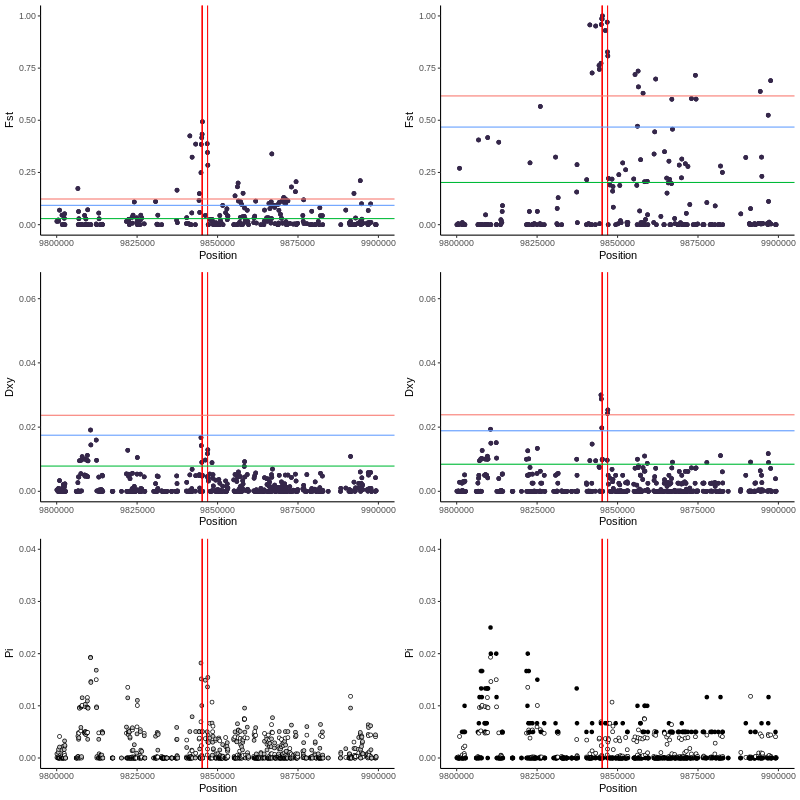

In [247]:
%%R -w 800 -h 800
full_plottable =     
    genome %>% 
    mutate(fst = ifelse(fst < 0, 0 ,fst)) %>%
    mutate(size = end - start) %>%
    filter(size > 98) %>%
    pivot_longer(cols = c(light,het,dark)) %>% 
    rename(pi = value, pop = name) %>%
    filter(pair == 'light_het') %>%
    mutate(midpoint = (end-start)/2 + start)
sig_snps = data.frame(pos = c(9845152,9845301,9846908))

start = 9800000
end = 9900000
fst_limits = c(0,1)
dxy_limits = c(0,0.065)
pi_limits = c(0,0.04)
base_color = wes_palette("Rushmore1")[4]

fstplot = 
    ggplot(full_plottable) +
    geom_point(aes(x = midpoint, y = fst), pch = 21, fill = base_color, color = base_color) +
    #facet_wrap(~pair, ncol = 1) +
    geom_vline(data = sig_snps, aes(xintercept = pos) , color = 'red') +
    geom_hline(data = light_het_outliers %>% filter(stat == "fst"), aes(yintercept = value, color = name)) +
    xlim(c(start, end)) +
    ylim(values = fst_limits) +
    ylab("Fst") +
    xlab("Position") +
    theme_classic() +
    theme(legend.position = 'none')

dxyplot = 
    ggplot(full_plottable) +
    geom_point(aes(x = midpoint, y = dxy), pch = 21, fill = base_color, color = base_color) +
    #facet_wrap(~pair, ncol = 1) +
    geom_vline(data = sig_snps, aes(xintercept = pos) , color = 'red') +
    geom_hline(data = light_het_outliers %>% filter(stat == "dxy"), aes(yintercept = value, color = name)) +
    xlim(c(start, end)) +
    ylim(dxy_limits) +
    ylab("Dxy") +
    xlab("Position") +
    theme_classic() +
    theme(legend.position = c(0.8,0.8)) +
    theme(legend.position = 'none')

piplot = 
    ggplot(full_plottable) +
    geom_point(aes(x = midpoint, y = pi, fill = pop), pch = 21) +
    geom_vline(data = sig_snps, aes(xintercept = pos), color = 'red') +
    scale_fill_manual(values = c('black','gray','white')) +
    #geom_hline(data = light_het_outliers %>% filter(stat == "dxy"), aes(yintercept = value, color = name)) +
    xlim(c(start, end)) +
    ylim(pi_limits) +
    ylab("Pi") +
    xlab("Position") +
    theme_classic() +
    theme(legend.position = 'none')

#print(piplot)
left = plot_grid(fstplot, dxyplot, piplot, ncol = 1, align = 'v')

full_plottable =     
    genome %>% 
    mutate(fst = ifelse(fst < 0, 0 ,fst)) %>%
    mutate(size = end - start) %>%
    filter(size > 98) %>%
    pivot_longer(cols = c(light,het,dark)) %>% 
    rename(pi = value, pop = name) %>%
    filter(pair == 'light_dark') %>%
    mutate(midpoint = (end-start)/2 + start)
sig_snps = data.frame(pos = c(9845152,9845301,9846908))
start = 9800000
end = 9900000

fstplot = 
    ggplot(full_plottable) +
    geom_point(aes(x = midpoint, y = fst), pch = 21, fill = base_color, color = base_color) +
    #facet_wrap(~pair, ncol = 1) +
    geom_vline(data = sig_snps, aes(xintercept = pos) , color = 'red') +
    geom_hline(data = light_dark_outliers %>% filter(stat == "fst"), aes(yintercept = value, color = name)) +
    xlim(c(start, end)) +
    ylim(values = fst_limits) +
    ylab("Fst") +
    xlab("Position") +
    theme_classic() +
    theme(legend.position = 'none')

dxyplot = 
    ggplot(full_plottable) +
    geom_point(aes(x = midpoint, y = dxy), pch = 21, fill = base_color, color = base_color) +
    #facet_wrap(~pair, ncol = 1) +
    geom_vline(data = sig_snps, aes(xintercept = pos) , color = 'red') +
    geom_hline(data = light_dark_outliers %>% filter(stat == "dxy"), aes(yintercept = value, color = name)) +
    xlim(c(start, end)) +
    ylim(dxy_limits) +
    ylab("Dxy") +
    xlab("Position") +
    theme_classic() +
    theme(legend.position = 'none')

piplot = 
    ggplot(full_plottable) +
    geom_point(aes(x = midpoint, y = pi, fill = pop), pch = 21) +
    geom_vline(data = sig_snps, aes(xintercept = pos) , color = 'red') +
    scale_fill_manual(values = c('black','gray','white')) +
    #geom_hline(data = light_het_outliers %>% filter(stat == "dxy"), aes(yintercept = value, color = name)) +
    xlim(c(start, end)) +
    ylim(pi_limits) +
    ylab("Pi") +
    xlab("Position") +
    theme_classic() +
    theme(legend.position = 'none')

#print(piplot)
right = plot_grid(fstplot, dxyplot, piplot, ncol = 1, align = 'v')

full = plot_grid(left,right)
print(full)
ggsave('~/temp/polionotus/RAWFIGS/DXY_PLOTS.svg', width = 8, height = 8)